# Fig 2. Paper version 

Bar plots for different thresholds/metrics


To do
- check whether to do mean/median, consistent in both? - for reporting use delta method to aggregate estimates??
- Decide on aesthetics / labels etc / how to communicate also the nahd per person
- make SI figure with normalized slopes for all metrics/thresholds
- double check sample_pi.py function on a single pixel to see it's working properly, try to understand why so different reanalysis v. models? 

see also: attr-hw-imsc2-isimp3b 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels??)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import matplotlib.patches as mpatches
from scipy.stats import norm
import pickle

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [2]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44967,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:41541,Total threads: 1
Dashboard: http://127.0.0.1:42359/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:42445,


In [4]:
figdir = os.path.join(figdirs, 'fig_sep24')


# Functions (finalize+move from here)

To do
- do median + IQR in all?
- finalise reporting fxns, check different ways of CI and aggregating/reporting result 

In [5]:
# model mean and range (not IQR)

def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  ax, 
                                                  year=2022, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 set_xticklabel=True,
                                                 rotation=40,
                                                 ylabel=None,
                                                 alpha_scale=False,
                                                 width=.5,
                                                 leg_title='Attributable days per year'):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.mean(dim='model')).values.T /unit
    lower_error = (da.mean(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1),
                                                        legend=False)
    else:
        bars = (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                        width=width,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1),
                                                               legend=False)
        # for SI figure - plot all the different thresholds with same color but different alphas
        if alpha_scale:
            alphas = np.linspace(0.2, 1, len(da_n_people_ndays_obs.features))
            for idx, bar_group in enumerate(bars.containers[1::2] ):  # 'containers' holds the bar groups for each dataset
                for bar in bar_group:
                    bar.set_alpha(alphas[idx])



    if ylabel is None:
        if proportion:
            ax.set_ylabel(f'Proportion of age group (%)')

        else:
            ax.set_ylabel(f'Number of people ({unit_str})')
    else:
        ax.set_ylabel(ylabel)

    ax.set_xlabel(' ')
    
    if set_xticklabel:
        step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  
                      rotation=rotation, rotation_mode='anchor',ha='right') #'horizontal'
    else:
        ax.set_xticklabels('')
    
    if legend==True:
        leg = ax.legend(labels = [f'$\geq${x}' for x in x_hot_days],
                  title=leg_title,
                 frameon=False,
                 fontsize=9,
                 handlelength=1.2,handletextpad=0.4,labelspacing = .1, # reduce spacing 
                bbox_to_anchor=(0, 1.2),
                  loc='upper left'
                 )
        leg._legend_box.align = "left"
        #leg.get_frame().set_linewidth(0.0)


In [6]:
def plot_percapitadays_median_iqr(da, 
                                  feature, 
                                  ax,
                                  set_xticklabel=True,
                                  set_xticks=True,
                                  ylabel='Per capita attributable \nhot-humid days per year',
                                 rotation=40,
                                 legend=False,
                                 leg_title=None,
                                 positions=range(1, 11),
                                 alpha=1,
                                 widths=0.5):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      widths=widths,
                      patch_artist=True,
                      showfliers=False,
                     positions=positions
                     ) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
        patch.set_facecolor(col)
        patch.set_edgecolor(col)
        patch.set_alpha(alpha)

    if set_xticklabel:
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], 
                      rotation=rotation,rotation_mode='anchor',ha='right');
    else:
        ax.set_xticklabels('')
        if not set_xticks:
            ax.set_xticks([])
            
    ax.set_ylabel(ylabel)

    if legend==True:
        leg = ax.legend(
                  title=leg_title,
                 frameon=False,
                 fontsize=9,
                 handlelength=1.2,handletextpad=0.4,labelspacing = .1, # reduce spacing 
                bbox_to_anchor=(0, 1.2),
                  loc='upper left'
                 )
        leg._legend_box.align = "left"


In [7]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

In [8]:
def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )

    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years

    # add dimension for correct multiplication
    days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})

    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 - da_p0) * days_in_month_da
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

In [9]:
def calc_nAHD_shift_fit_percentile(da_params, 
                                             percentile, 
                                             gmst_smo,
                                             year_pres=2023,
                                             GWI=1.3,
                                            mc_samplesize=1000,
                                            ):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    
    # Get params
    if len(da_params.params) > 3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0 + sigma_b1 * gmst_pi
        std_pres = sigma_b0 + sigma_b1 * gmst_pres
    else:
        sigma_b0 = da_params.sel(params='sigma')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0
        std_pres = sigma_b0

    # theoretical distributions per month in present for later 
    norm_pres = norm(loc=mean_pres, scale=std_pres)
    
    # Number of samples for Monte Carlo
    n_samples = mc_samplesize
    
    # Monte Carlo sampling function, reshaped to match the broadcasted dimensions
    def monte_carlo_samples(mean, std_dev, size):
        """Draw Monte Carlo samples from normal distribution."""
        samples_shape = mean.shape + (size,)  
        return norm.rvs(loc=mean, scale=std_dev, size=samples_shape)
    
    # Apply Monte Carlo sampling across all grid cells
    samples_pi = xr.apply_ufunc(
        monte_carlo_samples, mean_pi, std_pi,
        input_core_dims=[[], []],  
        output_core_dims=[['samples']],  # Output will add a `samples` dimension
        vectorize=True, dask='parallelized', kwargs={'size': n_samples}
    )

    # weights 
    coords = dict(month=("month", np.arange(1,13)))
    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years
    month_lengths = xr.DataArray(days_in_month, dims="month", coords=coords)
    
    # weigh the sample by month length and get qth percentile value 
    da_threshold = samples_pi.weighted(month_lengths).quantile(percentile, dim=['samples','month'])

    # expand dims
    da_threshold = da_threshold.expand_dims('month', axis=1)
    # get p of exceedance of pi 90th percentile threshold in each grid cell 
    data = norm_pres.sf(da_threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 -  (1 - percentile)) *  month_lengths 
    
    da_nAHD = da_nAHD_mo.sum(dim='month')

    # clean up for memory
    del samples_pi, da_threshold


    return da_nAHD, da_nAHD_mo, da_threshold, da_p1

In [10]:
def sample_from_monthly_pi_distributions(da_params,
                                         gmst_smo,
                                         year_pres=2023,
                                         GWI=1.3,
                                         mc_samplesize=1000,
                                            ):


    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)
    
    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    
    # Get params
    if len(da_params.params) > 3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0 + sigma_b1 * gmst_pi
        std_pres = sigma_b0 + sigma_b1 * gmst_pres
    else:
        sigma_b0 = da_params.sel(params='sigma')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0
        std_pres = sigma_b0
    
    # Number of samples for Monte Carlo
    n_samples = mc_samplesize
    
    # Monte Carlo sampling function, reshaped to match the broadcasted dimensions
    def monte_carlo_samples(mean, std_dev, size):
        """Draw Monte Carlo samples from normal distribution."""
        samples_shape = mean.shape + (size,)  
        return norm.rvs(loc=mean, scale=std_dev, size=samples_shape)
    
    # Apply Monte Carlo sampling across all grid cells
    samples_pi = xr.apply_ufunc(
        monte_carlo_samples, mean_pi, std_pi,
        input_core_dims=[[], []],  
        output_core_dims=[['samples']],  # Output will add a `samples` dimension
        vectorize=True, dask='parallelized', kwargs={'size': n_samples}
    )

    return samples_pi
                                      

In [11]:
def calc_nAHD_shift_fit_percentile_from_sample(da_params, 
                                             percentile, 
                                             gmst_smo,
                                               samples_pi,
                                             year_pres=2023,
                                             GWI=1.3,
                                            #mc_samplesize=1000,
                                            ):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    
    # Get params
    if len(da_params.params) > 3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0 + sigma_b1 * gmst_pi
        std_pres = sigma_b0 + sigma_b1 * gmst_pres
    else:
        sigma_b0 = da_params.sel(params='sigma')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0
        std_pres = sigma_b0

    # theoretical distributions per month in present for later 
    norm_pres = norm(loc=mean_pres, scale=std_pres)
    

    # weights 
    coords = dict(month=("month", np.arange(1,13)))
    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years
    weights = xr.DataArray(days_in_month, dims="month", coords=coords)
    
    # weigh the sample by month length and get qth percentile value 
    da_threshold = samples_pi.weighted(weights).quantile(percentile, dim=['samples','month'])

    # expand dims
    da_threshold = da_threshold.expand_dims('month', axis=1)
    # get p of exceedance of pi 90th percentile threshold in each grid cell 
    data = norm_pres.sf(da_threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 -  (1 - percentile)) *  weights 
    
    da_nAHD = da_nAHD_mo.sum(dim='month')

    return da_nAHD, da_nAHD_mo, da_threshold, da_p1
    

# Data prep

## 0. Population preprocessing


In [12]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

# add message that say n of countries !

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## 1. nAHD: WBGT28

Obs:loc only models



In [13]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []
startyear=1950

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_{str(startyear)}_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [14]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
#gmst_smo

In [15]:
threshold = 28
GWI=1.3

from scipy.stats import norm

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=GWI)

/tmp/ipykernel_1219268/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [16]:
da_nAHD = da_nAHD_obs.rename({'dataset':'model'})

da_n_people_ndays_obs, da_prop_people_ndays_obs = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 2. nAHD (WBGT28): Climate models 

In [17]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 


In [18]:
da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 3. WBGT30

In [19]:
# Observations 

threshold = 30

da_nAHD_obs_30, da_nAHD_mo_30, da_p0_30, da_p1_30 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_30.rename({'dataset':'model'})

da_n_people_ndays_obs_30, da_prop_people_ndays_obs_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

/tmp/ipykernel_1219268/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [20]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_30 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_30

da_n_people_ndays_models_30, da_prop_people_ndays_models_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 4. WBGT33 (maybe don't include?)

In [21]:
threshold = 33

da_nAHD_obs_33, da_nAHD_mo_33, da_p0_33, da_p1_33 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_33.rename({'dataset':'model'})

da_n_people_ndays_obs_33, da_prop_people_ndays_obs_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

/tmp/ipykernel_1219268/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [22]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_33 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_33

da_n_people_ndays_models_33, da_prop_people_ndays_models_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 5. WBGT90,95,99 

### Models 

In [23]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_W99 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W99

da_n_people_ndays_models_W99, da_prop_people_ndays_models_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [24]:

da_nAHD_models_W90 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W90

da_n_people_ndays_models_W90, da_prop_people_ndays_models_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                           mask_where_decr=False
                                                                           )

In [25]:

da_nAHD_models_W95 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W95

da_n_people_ndays_models_W95, da_prop_people_ndays_models_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Obs

In [29]:
inDIR=os.path.join(outdirs,f'output_shift-fit/forster2024/WBGT/ISIMIP3a/sample_pi/GWI{str(GWI)}/')

pctl=0.9
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{str(startyear)}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W90, da_nAHD_obs_mo_W90, da_threshold_obs_W90, da_p1_obs_W90 = [ xr.open_dataarray(f) for f in files] 

pctl=0.95
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{str(startyear)}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W95, da_nAHD_obs_mo_W95, da_threshold_obs_W95, da_p1_obs_W95 = [ xr.open_dataarray(f) for f in files] 

pctl=0.99
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{str(startyear)}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W99, da_nAHD_obs_mo_W99, da_threshold_obs_W99, da_p1_obs_W99 = [ xr.open_dataarray(f) for f in files] 


In [34]:
print(startyear, GWI)

1950 1.3


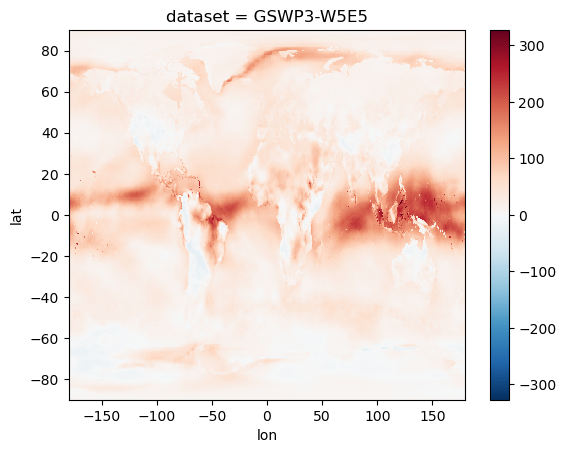

In [31]:
da_nAHD_obs_W90.isel(dataset=0).plot()

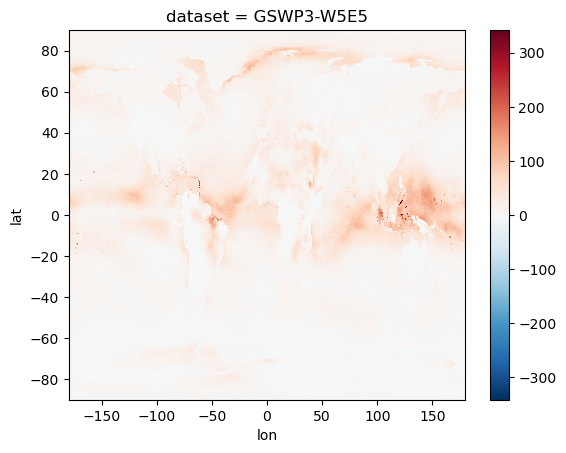

In [32]:
da_nAHD_obs_W99.isel(dataset=0).plot()

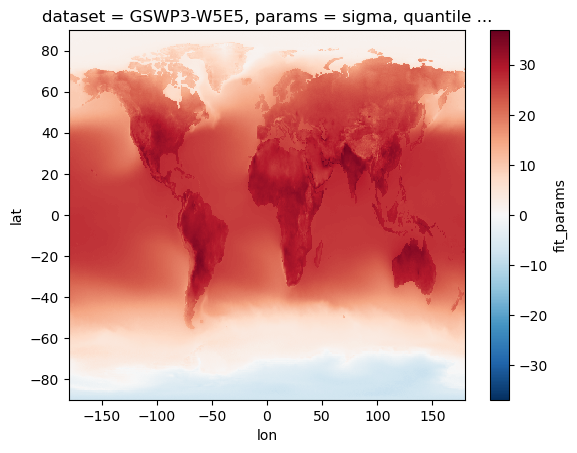

In [33]:
da_threshold_obs_W99.isel(dataset=0).plot()

In [35]:

da_nAHD = da_nAHD_obs_W99.rename({'dataset':'model'})

da_n_people_ndays_obs_W99, da_prop_people_ndays_obs_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [36]:

da_nAHD = da_nAHD_obs_W95.rename({'dataset':'model'})

da_n_people_ndays_obs_W95, da_prop_people_ndays_obs_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [37]:

da_nAHD = da_nAHD_obs_W90.rename({'dataset':'model'})

da_n_people_ndays_obs_W90, da_prop_people_ndays_obs_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


## 6. TX95, TX99 : todo obs !

TODO: run shift fit on tasmax in obs ! and run EP on new extra models

In [38]:
da_nAHD_TX90_models = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname, year_pres=year) 
da_nAHD_TX95_models = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname, year_pres=year)  
da_nAHD_TX99_models = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year_pres=year) 

In [39]:
da_nAHD = da_nAHD_TX90_models

da_n_people_ndays_models_TX90, da_prop_people_ndays_models_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [40]:
da_nAHD = da_nAHD_TX95_models

da_n_people_ndays_models_TX95, da_prop_people_ndays_models_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [41]:
da_nAHD = da_nAHD_TX99_models

da_n_people_ndays_models_TX99, da_prop_people_ndays_models_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

# Supplementary figures: part 1 bar plots

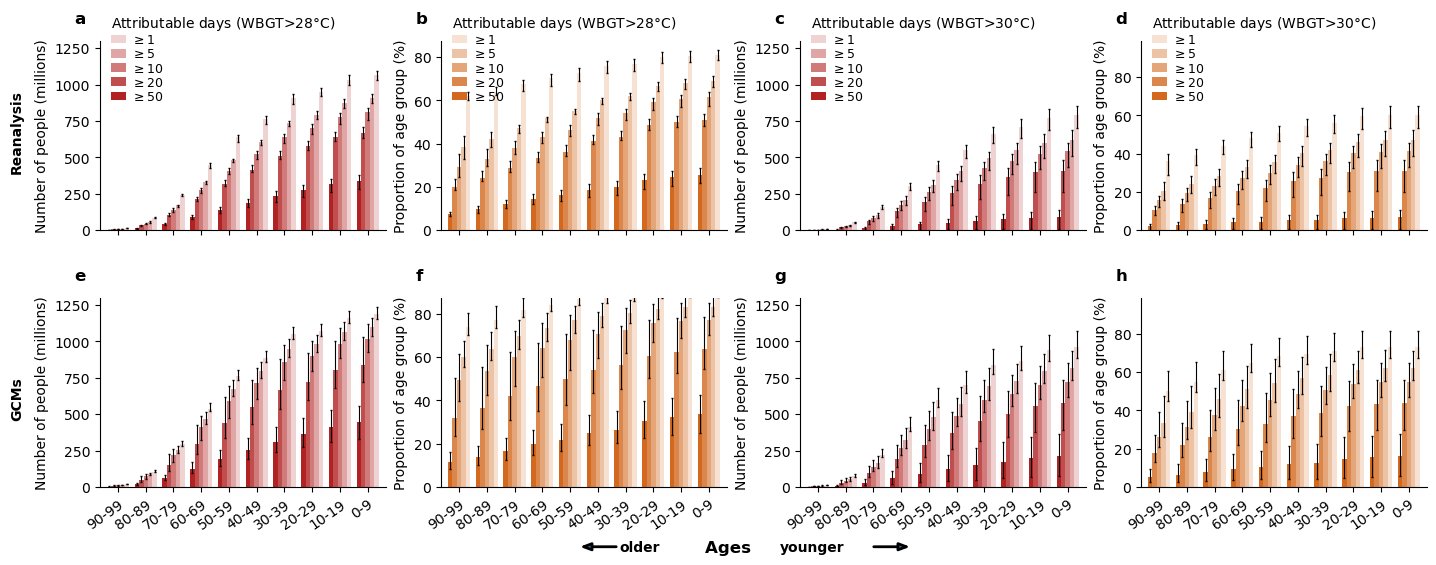

In [42]:
# settings
xpos=-.09
ypos=1.05


fig,axes=plt.subplots(2,4,figsize=(14,5.5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>28$\degree$C)',
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              alpha_scale=True,
                                              width=.8,
)


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>28$\degree$C)',
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)',
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[2]
ax.set_ylim(axes[0].get_ylim())
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs_30, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>30$\degree$C)',
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              alpha_scale=True,
                                              width=.8,
                                             )



ax=axes[3]
ax.set_ylim(axes[1].get_ylim())
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs_30 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>30$\degree$C)',
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)',
                                              alpha_scale=True,
                                              width=.8,
                                             )




ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)',
                                             alpha_scale=True,
                                              width=.8,)

ax=axes[6]
ax.set_ylim(axes[4].get_ylim())
ax.set_title('g',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models_30, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[7]
ax.set_ylim(axes[5].get_ylim())
ax.set_title('h',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models_30 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)',
                                             alpha_scale=True,
                                              width=.8,)



# Scale y axes to match
axes[0].set_ylim(axes[4].get_ylim())
axes[2].set_ylim(axes[6].get_ylim())
axes[5].set_ylim(axes[1].get_ylim())
axes[3].set_ylim(axes[7].get_ylim())




# Annotations 
fig.text(-.015,.7, 'Reanalysis', ha='left',rotation=90, fontweight='bold');
fig.text(-.015,.25, 'GCMs', ha='left',rotation=90, fontweight='bold');
fig.supxlabel('Ages ', y=0,fontweight='bold'); #c='0.5',size=14


# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.535, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


#plt.savefig(os.path.join(figdir,'fig2_SI_part1.png'),dpi=300,bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(figdir,'fig2_SI_part1.pdf'),dpi=300,bbox_inches='tight',transparent=True)

### summary results: WBGT28

In [55]:
da_n_people_ndays_obs.mean(dim='model').to_pandas().applymap(format_large_numbers) # 28 degrees 

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,1.1B,904.9M,810.5M,670.2M,337.7M
10,1.0B,871.8M,777.8M,640.1M,314.0M
20,950.8M,793.4M,704.5M,576.2M,273.9M
30,908.5M,732.5M,636.9M,509.4M,233.1M
40,763.7M,604.3M,521.5M,414.6M,188.3M
50,637.7M,482.6M,405.7M,316.8M,141.2M
60,448.4M,329.4M,273.6M,211.8M,93.2M
70,243.6M,170.0M,137.2M,103.4M,43.9M
80,86.6M,57.0M,44.8M,32.7M,13.2M


In [57]:
(da_prop_people_ndays_obs * 100).mean(dim='model').to_pandas().round(2)

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,80.96,68.83,61.65,50.98,25.68
10,80.53,67.93,60.61,49.88,24.46
20,79.93,66.69,59.22,48.43,23.03
30,77.01,62.09,53.99,43.18,19.76
40,75.85,60.02,51.80,41.17,18.70
50,72.87,55.14,46.35,36.19,16.13
60,70.26,51.62,42.87,33.19,14.60
70,67.49,47.09,38.01,28.63,12.17
80,64.08,42.14,33.12,24.18,9.78


In [58]:
da_n_people_ndays_models.mean(dim='model').to_pandas().applymap(format_large_numbers)

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,1.2B,1.1B,1.0B,838.7M,444.6M
10,1.2B,1.1B,984.5M,801.3M,413.9M
20,1.1B,980.3M,899.8M,722.5M,362.1M
30,1.0B,948.1M,857.3M,664.4M,310.5M
40,884.0M,793.7M,712.4M,546.1M,251.5M
50,759.9M,673.5M,593.3M,436.6M,189.9M
60,537.9M,469.2M,409.0M,296.7M,125.5M
70,294.8M,252.1M,216.2M,151.0M,60.2M
80,104.1M,86.5M,72.7M,49.2M,18.8M


In [60]:
(da_prop_people_ndays_models*100).mean(dim='model').to_pandas().round(2)

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,90.24,83.37,77.39,63.80,33.82
10,90.20,83.06,76.72,62.44,32.26
20,89.89,82.41,75.64,60.73,30.44
30,88.75,80.37,72.67,56.32,26.32
40,87.80,78.83,70.75,54.23,24.98
50,86.83,76.95,67.79,49.88,21.70
60,84.29,73.53,64.10,46.50,19.66
70,81.65,69.84,59.88,41.84,16.69
80,77.04,63.97,53.81,36.40,13.93


### summary results: WBGT30

In [61]:
da_n_people_ndays_models_30.mean(dim='model').to_pandas().applymap(format_large_numbers)

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,961.5M,815.3M,721.6M,576.1M,215.1M
10,939.5M,794.7M,700.9M,555.3M,199.8M
20,866.9M,729.0M,640.5M,503.6M,174.0M
30,838.9M,691.5M,595.4M,454.4M,148.4M
40,701.1M,571.7M,489.3M,370.5M,120.7M
50,597.0M,477.0M,398.2M,289.8M,91.8M
60,414.0M,325.2M,269.5M,194.2M,60.7M
70,220.4M,166.4M,135.2M,94.6M,28.5M
80,74.1M,53.1M,42.6M,29.5M,8.8M


## WBGT33 ?

Quite different scale maybe not so relevant? check if nAHD per capita pattern still holds here

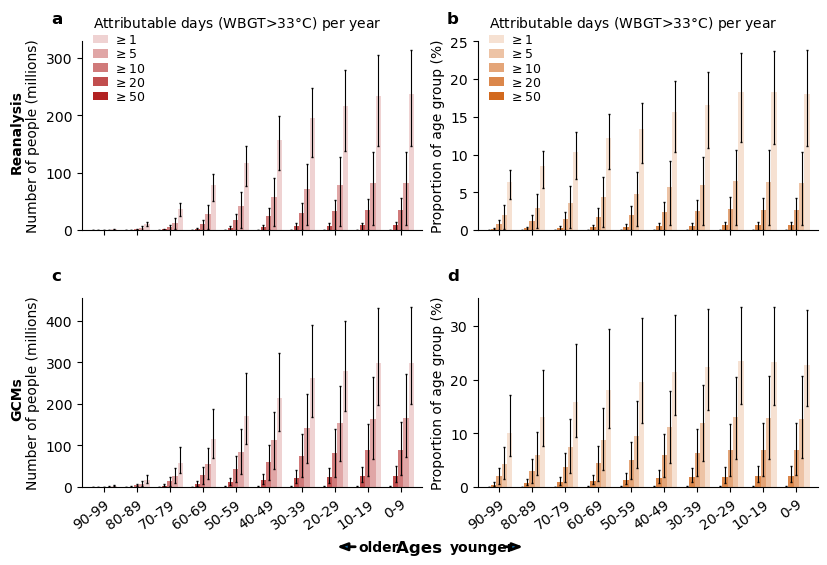

In [43]:
# settings
xpos=-.09
ypos=1.05


fig,axes=plt.subplots(2,2,figsize=(8,5.5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs_33, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>33$\degree$C) per year',
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              alpha_scale=True,
                                              width=.8,
)


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs_33 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>33$\degree$C) per year',
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)',
                                              alpha_scale=True,
                                              width=.8,
                                             )




ax=axes[2]
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models_33, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models_33 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)',
                                             alpha_scale=True,
                                              width=.8,)




# Annotations 
fig.text(-.015,.7, 'Reanalysis', ha='left',rotation=90, fontweight='bold');
fig.text(-.015,.25, 'GCMs', ha='left',rotation=90, fontweight='bold');
fig.supxlabel('Ages ', y=0,fontweight='bold'); #c='0.5',size=14


# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.535, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#plt.savefig(os.path.join(figdir,'fig2_SI_wbgt33.png'),dpi=300,bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(figdir,'fig2_SI_wbgt33.pdf'),dpi=300,bbox_inches='tight',transparent=True)

## Percentiles: WBGT90,95,99?

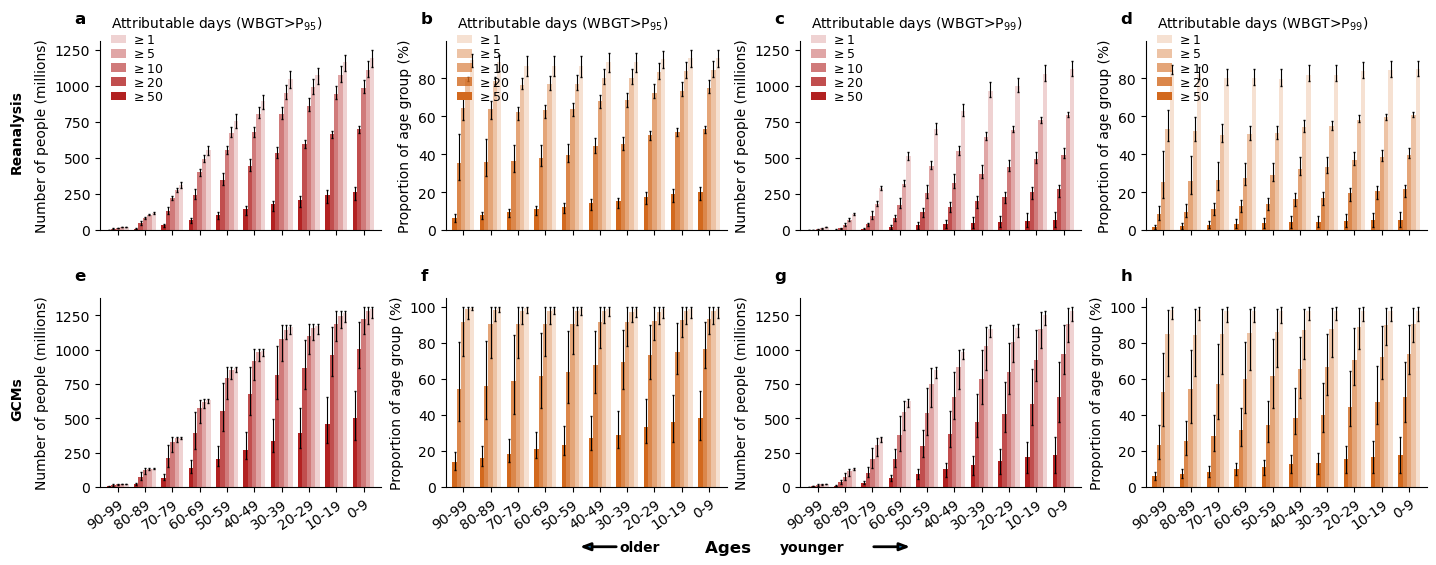

In [44]:
# settings
xpos=-.09
ypos=1.05


fig,axes=plt.subplots(2,4,figsize=(14,5.5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs_W95, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>P$_{95}$)',
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              alpha_scale=True,
                                              width=.8,
)


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs_W95 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>P$_{95}$)',
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)',
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[2]
ax.set_ylim(axes[0].get_ylim())
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_obs_W99, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>P$_{99}$)',
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=False,
                                              alpha_scale=True,
                                              width=.8,
                                             )



ax=axes[3]
ax.set_ylim(axes[1].get_ylim())
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_obs_W99 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=True,
                                              leg_title='Attributable days (WBGT>P$_{99}$)',
                                              errcolor='k',
                                              color='chocolate',
                                              set_xticklabel=False,
                                              ylabel='Proportion of age group (%)',
                                              alpha_scale=True,
                                              width=.8,
                                             )




ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models_W95, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models_W95 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)',
                                             alpha_scale=True,
                                              width=.8,)

ax=axes[6]
ax.set_ylim(axes[4].get_ylim())
ax.set_title('g',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays_models_W99, 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              set_xticklabel=True,
                                              rotation=35,
                                              alpha_scale=True,
                                              width=.8,
                                             )

ax=axes[7]
ax.set_ylim(axes[5].get_ylim())
ax.set_title('h',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays_models_W99 * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              rotation=35,
                                             ylabel='Proportion of age group (%)',
                                             alpha_scale=True,
                                              width=.8,)



# Annotations 
fig.text(-.015,.7, 'Reanalysis', ha='left',rotation=90, fontweight='bold');
fig.text(-.015,.25, 'GCMs', ha='left',rotation=90, fontweight='bold');
fig.supxlabel('Ages ', y=0,fontweight='bold'); #c='0.5',size=14


# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.535, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# plt.savefig(os.path.join(figdir,'fig2_SI_part2.png'),dpi=300,bbox_inches='tight',transparent=True)
# plt.savefig(os.path.join(figdir,'fig2_SI_part2.pdf'),dpi=300,bbox_inches='tight',transparent=True)

## TX95, TX99 

# Suppl figure: part 2 days per cap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


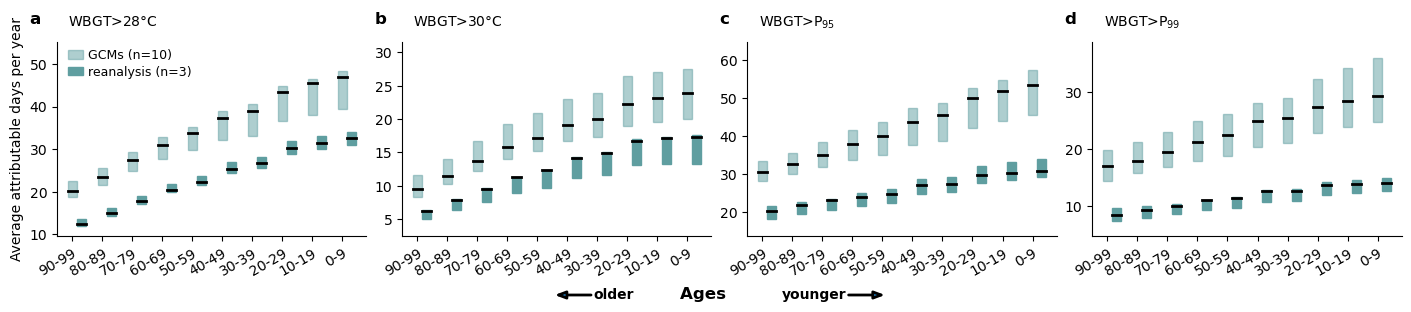

In [45]:
# settings
xpos=-.09
ypos=1.05
shift = 0.15

fig,axes=plt.subplots(1,4,figsize=(14,3),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                             #ylabel='Average attributable days per year',
                              legend=True, 
                              leg_title='WBGT>28$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                              
                             rotation=30,
                             ylabel='Average attributable days per year',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>30$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                              
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[2]
#ax.set_ylim(axes[0].get_ylim())
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{95}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{99}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )


titles = ['WBGT>28$\degree$C',
          'WBGT>30$\degree$C',
          'WBGT>P$_{95}$',
          'WBGT>P$_{99}$'

]

for ax in [axes[0]]:
    mod_patch = mpatches.Patch(color='cadetblue', alpha=0.5, label='GCMs (n=10)')
    obs_patch = mpatches.Patch(color='cadetblue', label='reanalysis (n=3)')
    leg = ax.legend(handles = [mod_patch, obs_patch ], fontsize=9,frameon=False, loc='upper left',
              handlelength=1.2,handletextpad=0.4,labelspacing = .3,
                    bbox_to_anchor=(0, 1.2),
             title=titles[0]+'\n') 
    leg._legend_box.align = "left"




# Annotations 
fig.supxlabel('Ages ', fontweight='bold'); 




# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.035), (0.63, 0.035),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.554, 0.035, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.035), (.39, 0.035),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.035, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Try as dots instead of IQR bar??

    
# plt.savefig(os.path.join(figdir,'fig2_SI_part3_percap.png'),dpi=300,bbox_inches='tight',transparent=True)
# plt.savefig(os.path.join(figdir,'fig2_SI_part3_percap.pdf'),dpi=300,bbox_inches='tight',transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

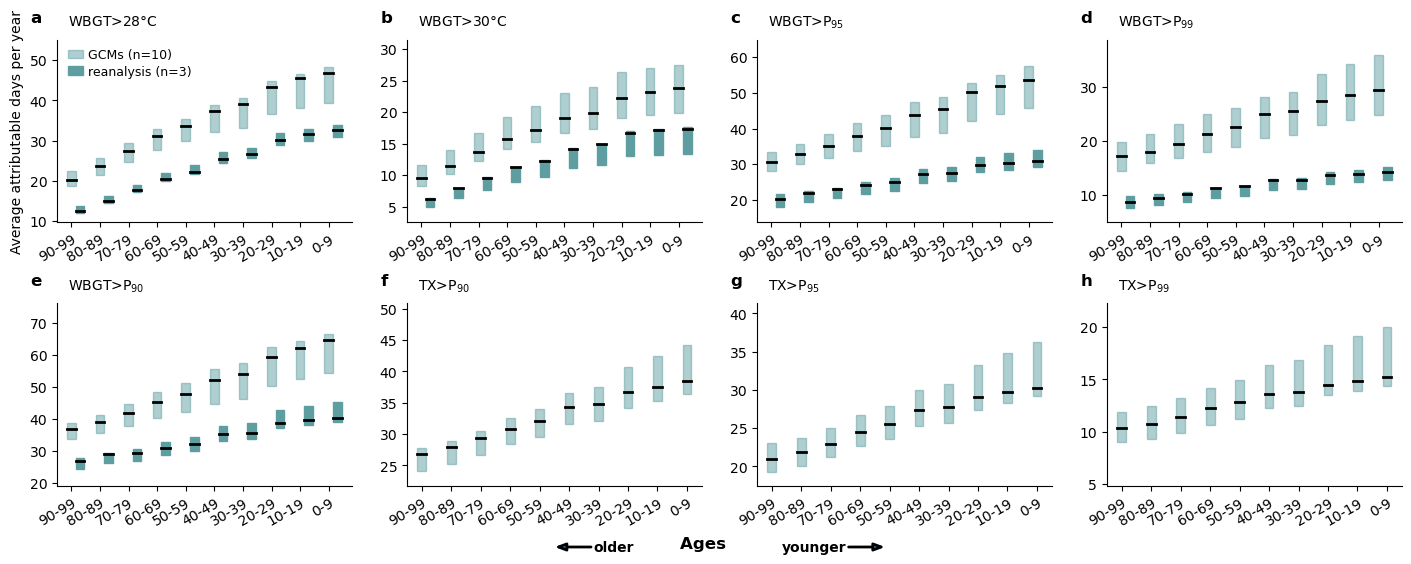

In [46]:
# settings
xpos=-.09
ypos=1.05
shift = 0.15

fig,axes=plt.subplots(2,4,figsize=(14,5.5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                             #ylabel='Average attributable days per year',
                              legend=True, 
                              leg_title='WBGT>28$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                              
                             rotation=30,
                             ylabel='Average attributable days per year',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>30$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                              
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[2]
#ax.set_ylim(axes[0].get_ylim())
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{95}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{99}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )


ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{90}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{90}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[6]
ax.set_title('g',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{95}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )





ax=axes[7]
ax.set_title('h',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{99}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )





# not really using this loop - clean up 
titles = ['WBGT>28$\degree$C',
          'WBGT>30$\degree$C',
          'WBGT>P$_{95}$',
          'WBGT>P$_{99}$'

]

for ax in [axes[0]]:
    mod_patch = mpatches.Patch(color='cadetblue', alpha=0.5, label='GCMs (n=10)')
    obs_patch = mpatches.Patch(color='cadetblue', label='reanalysis (n=3)')
    leg = ax.legend(handles = [mod_patch, obs_patch ], fontsize=9,frameon=False, loc='upper left',
              handlelength=1.2,handletextpad=0.4,labelspacing = .3,
                    bbox_to_anchor=(0, 1.2),
             title=titles[0]+'\n') 
    leg._legend_box.align = "left"




# Annotations 
fig.supxlabel('Ages ', fontweight='bold'); 




# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.554, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Try as dots instead of IQR bar??

#plt.savefig(os.path.join(figdir,'fig2_SI_part3_percap_v2.png'),dpi=300,bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(figdir,'fig2_SI_part3_percap_v2.pdf'),dpi=300,bbox_inches='tight',transparent=True)

In [62]:
da_nAHD_percapita_peopledays_10y_obs_W99.sel(features='per_capita_days').to_pandas().T

model,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
age_ranges,,,
0,14.145169,15.914978,11.073014
10,13.873080,15.377504,10.669108
20,13.672177,14.788724,10.264459
30,12.720686,13.360692,9.234930
40,12.645038,12.987688,8.914942
50,11.547611,11.788515,8.028614
60,11.186143,11.117729,7.662016
70,10.803753,10.102697,7.167334
80,10.854175,9.312805,6.787840


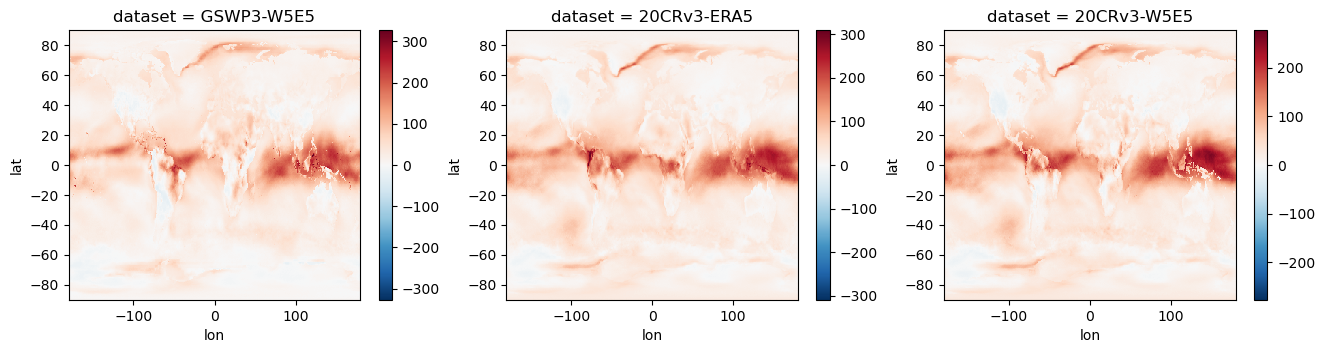

In [47]:
fig,axes = plt.subplots(1,3, figsize=(16,3.5))

for i in range(3):
    da_nAHD_obs_W90.isel(dataset=i).plot(ax=axes[i])


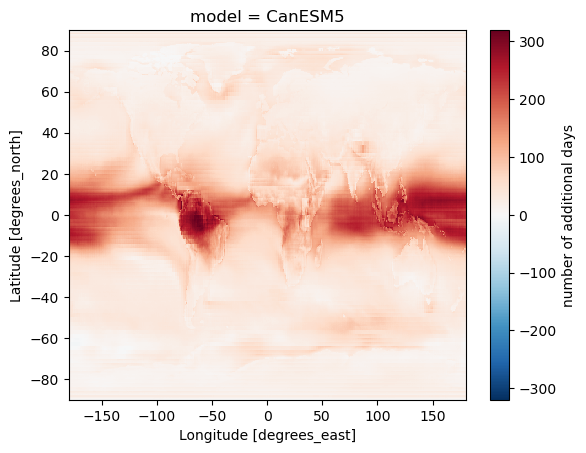

In [48]:
da_nAHD_models_W90.isel(model=0).plot()